# Kaggle - Regression - Housing Price Market Predictions

## Jules MOTYL / Sébastien PAVOT

## Libraries:

In [20]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib
from scipy import stats
from scipy.stats import norm

## Data importation:

In [32]:
Data = "C:/Users/spavot/Documents/GitHub/Kaggle-Competition-Regression-HousingPriceMarket-Python/Data/"

In [34]:
train = pd.read_csv(Data + "train.csv")

In [35]:
test = pd.read_csv(Data + "test.csv")

We create a full dataset by stacking train & test data, this dataset will be used to process the data and after we will divide it again into train and test set:

In [36]:
full = all_data = pd.concat((train, test)).reset_index(drop=True)
full = full.drop(['SalePrice'], axis =1)
full.shape

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  """Entry point for launching an IPython kernel.


(2919, 80)

Now that we've cleaned and preprocessed the data, we divide the full dataset into the train and test previously loaded:

In [29]:
ntrain = train.shape[0]
ntest = test.shape[0]
y_train = train.SalePrice.values

In [30]:
train = full[:ntrain]
test = full[ntrain:]

## Part 1: Data exploration:

### Analyze the dependent variable : SalePrice

In [5]:
#descriptive statistics summary
train['SalePrice'].describe()

count      1460.000000
mean     180921.195890
std       79442.502883
min       34900.000000
25%      129975.000000
50%      163000.000000
75%      214000.000000
max      755000.000000
Name: SalePrice, dtype: float64

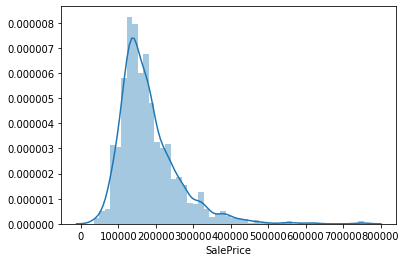

In [6]:
#Histogram vizualisation
sns.distplot(train['SalePrice']);

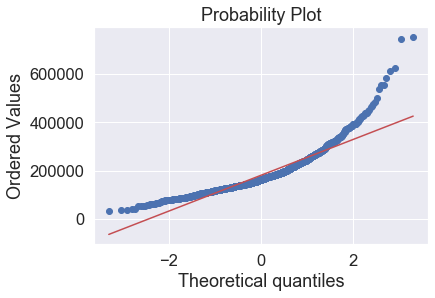

In [17]:
#Get also the QQ-plot
fig = plt.figure()
res = stats.probplot(train['SalePrice'], plot=plt)
plt.show()

We can see that the SalePrice variable is right skewed meaning that we will found a small amount of house that have a price way higher than the median.

We can see that it's not normally distributed, here we would like to get a normal distribution.

Now, we check the 11 variables that are the most correlated with SalePrice using the corr() function. Let's print it in a heatmap using seaborn in order to have a good vizualisation:

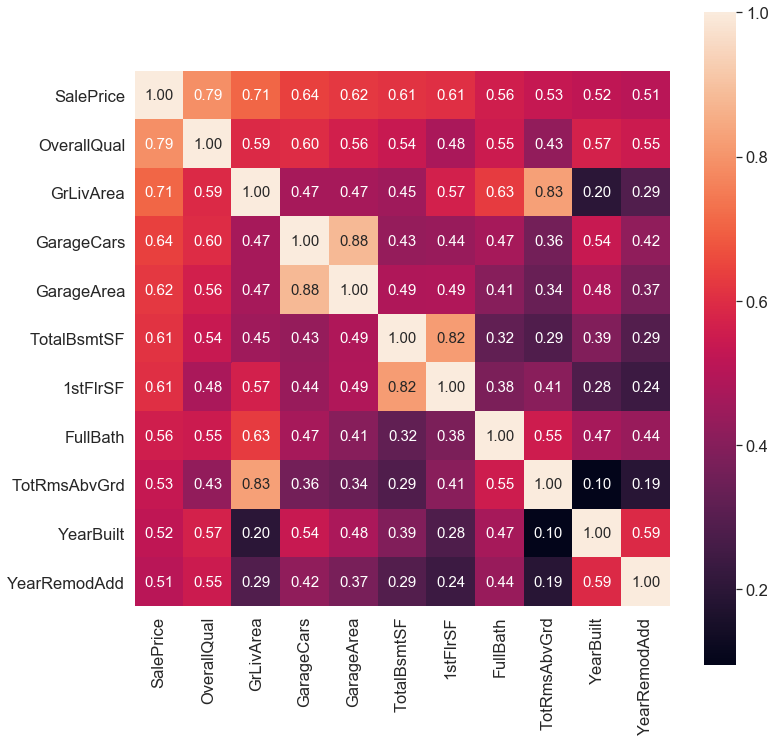

In [7]:
#saleprice correlation matrix
corrmat = train.corr()
k = 11 #number of variables for heatmap
cols = corrmat.nlargest(k, 'SalePrice')['SalePrice'].index
cm = np.corrcoef(train[cols].values.T)
sns.set(font_scale=1.50)
fig, ax = plt.subplots(figsize=(12,12))  
hm = sns.heatmap(cm, cbar=True, annot=True, square=True, fmt='.2f', annot_kws={'size': 15}, yticklabels=cols.values, xticklabels=cols.values)
plt.show()

As example, we can see that SalePrice and GarageCars are correlated but GarageCar is nearly strongly correlated with OverallQual. Here the size of the garage seems to be correlated with the overall quality of the material and the finish of the house. It's seems to be logical but we can maybe find stronger correlation between OverallQual and GarageQual as the garage quality will definitely have an impact on the overall quality.

The eleven most correlated variable with SalePrice are:
 * OverallQual
 * GrLivArea
 * GarageCars
 * GarageArea
 * TotalBsmtSF
 * 1stFlrSF
 * FullBath
 * TotRmsAbvGrd
 * YearBuilt
 * YearRemodAdd

Now that we've more comprehension of the dependent variable, let's have a first look at the predictors:

### Analyze the predictors:

Bellow, we plot a correlation heatmap using once again seaborn in order to have a quick overall ideal of correlation between all the variables:

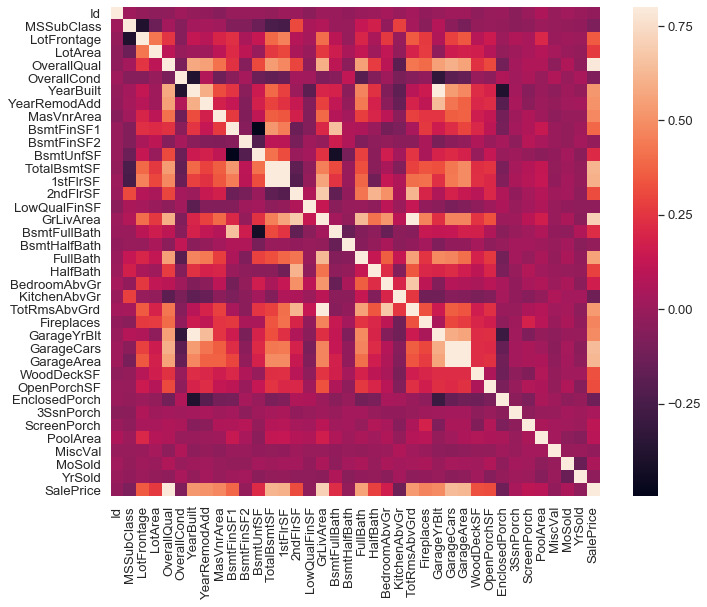

In [52]:
corrmat = train.corr()
sns.set(font_scale= 1.2)
f, ax = plt.subplots(figsize=(12, 9))
sns.heatmap(corrmat, vmax=.8, square=True, xticklabels=True, yticklabels=True);

We've now an overview of the correlation, as a macro view, we can say that some variables are correlated together wether negatively or positvely. This fact might lead to multicolinearity in our modeling part so we have to take this into account and to avoid that in order to have a better model. One can enjoy spend time of looking at correlation for each predictor but we won't dig into details here.

### Missing value analysis:

We will first create a dataframe containing the missing ratio (in percentage) of all predictors containing missing values:

In [41]:
#the dataset:
full_na = (full.isnull().sum() / len(all_data)) * 100
#We now remove the obervations where there's no missing values and sort it descennding
full_na = full_na.drop(full_na[full_na == 0].index).sort_values(ascending=False)

In [45]:
#We create a varibale containing the percentage of missing values by diving the sum of missing values by the length of 
#the dataset:
full_na = (full.isnull().sum() / len(all_data)) * 100
#We now remove the obervations where there's no missing values and sort it descennding
full_na = full_na.drop(full_na[full_na == 0].index).sort_values(ascending=False)
#We name this column and turn the full_na into a dataframe and then print it:
missing_data = pd.DataFrame({'Missing Ratio' :full_na})
missing_data

Missing Ratio
PoolQC            99.657417
MiscFeature       96.402878
Alley             93.216855
Fence             80.438506
FireplaceQu       48.646797
LotFrontage       16.649538
GarageQual         5.447071
GarageCond         5.447071
GarageFinish       5.447071
GarageYrBlt        5.447071
GarageType         5.378554
BsmtExposure       2.809181
BsmtCond           2.809181
BsmtQual           2.774923
BsmtFinType2       2.740665
BsmtFinType1       2.706406
MasVnrType         0.822199
MasVnrArea         0.787941
MSZoning           0.137033
BsmtFullBath       0.068517
BsmtHalfBath       0.068517
Utilities          0.068517
Functional         0.068517
Electrical         0.034258
BsmtUnfSF          0.034258
Exterior1st        0.034258
Exterior2nd        0.034258
TotalBsmtSF        0.034258
GarageArea         0.034258
GarageCars         0.034258
BsmtFinSF2         0.034258
BsmtFinSF1         0.034258
KitchenQual        0.034258
SaleType           0.034258

We now plot this into an horizontal barchart for more visualization:

Text(0.5, 1.0, 'Percentages of missing values per features')

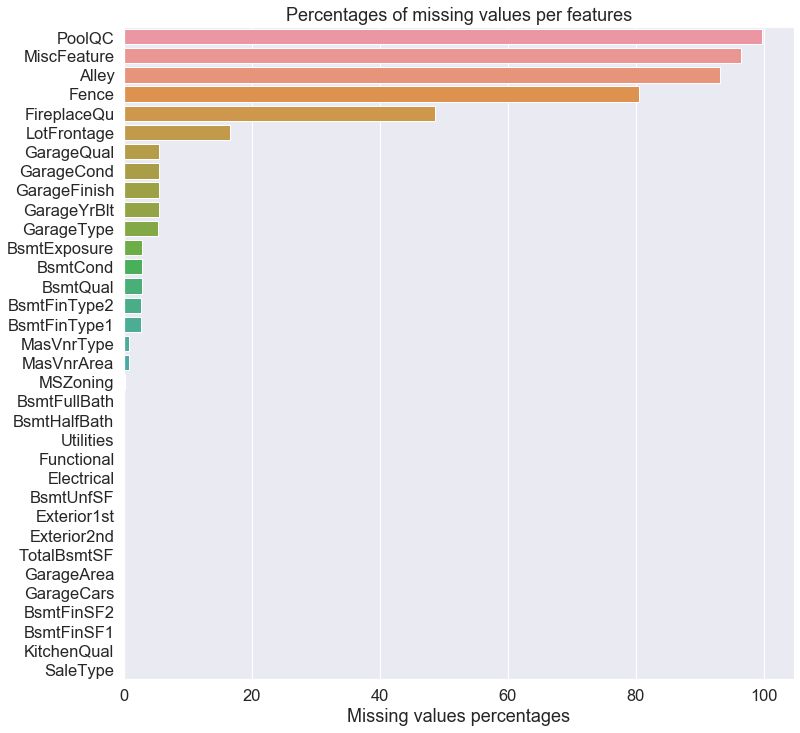

In [49]:
#Adapt the size of the plot
fig, ax = plt.subplots(figsize=(12,12))
#Plot the barplot
sns.barplot(x = full_na, y = full_na.index)
#Add labels
plt.xlabel("Missing values percentages")
plt.title("Percentages of missing values per features")

### Outliers analysis:

The dataset descriptions give us the following about outliers: _"Potential Pitfalls (Outliers): Although all known errors were corrected in the data, no
observations have been removed due to unusual values and all final residential sales
from the initial data set are included in the data presented with this article. There are
five observations that an instructor may wish to remove from the data set before giving
it to students (a plot of SALE PRICE versus GR LIV AREA will quickly indicate these
points). Three of them are true outliers (Partial Sales that likely don’t represent actual
market values) and two of them are simply unusual sales (very large houses priced
relatively appropriately). I would recommend removing any houses with more than
4000 square feet from the data set (which eliminates these five unusual observations)
before assigning it to students."_

Let's plot SalePrice versus GR LIV AREA:

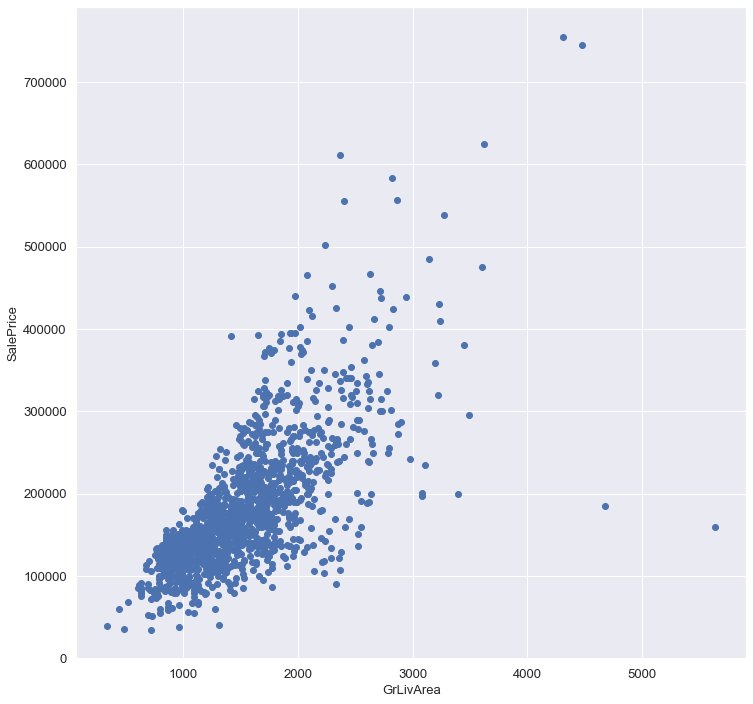

In [56]:
fig, ax = plt.subplots(figsize=(12,12))
ax.scatter(x = train['GrLivArea'], y = train['SalePrice'])
plt.ylabel('SalePrice', fontsize=13)
plt.xlabel('GrLivArea', fontsize=13)
plt.show()

## Part 2: Data Processing:

### Outliers detection and treatment: